In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

### Pre-processing Granja et al 2019 data

Data was downloaded as rds files either from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139369) or from their [GitHub](https://github.com/GreenleafLab/MPAL-Single-Cell-2019). See `../rscripts/pre_processing_granja.R` for pre-pre-processing steps that produced these files. 

In [2]:
# read in data
adata = sc.read('../data/granja/gran_rna.mtx') # rna expression matrix
adata.var_names = pd.read_csv('../data/granja/gran_rna_genes.csv', sep='\t')['gene_symbol'] # gene names
meta = pd.read_csv('../data/granja/gran_rna_meta.csv', sep='\t') # metadata
meta['bc'] = meta['Group'] + ':' + meta['Barcode'] # need to update barcode index to match ADT files
meta.index = meta['bc']
adt  = pd.read_csv('../data/granja/gran_adt_clr.csv', sep='\t') # read in ADT data
adt.fillna(0, inplace = True) # replace NAs with 0s
adata.obs_names = meta['bc'] # set obs names
adata.obs = pd.concat([meta, adt], axis=1) # add metadata to adata object
adata

/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


AnnData object with n_obs × n_vars = 20778 × 20287
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'BioClassification', 'Barcode', 'bc', 'ADT_CD10', 'ADT_CD123', 'ADT_CD14', 'ADT_CD19', 'ADT_CD3', 'ADT_CD33', 'ADT_CD34', 'ADT_CD38', 'ADT_CD4', 'ADT_CD45RA', 'ADT_CD7', 'ADT_CD8A', 'ADT_CD90', 'ADT_CD15', 'ADT_CD16', 'ADT_CD56', 'ADT_CD25', 'ADT_CD45RO', 'ADT_PD.1', 'ADT_TIGIT', 'ADT_CD127'

This dataset comes with some metadata such as UMAP coordinates and BioClassification (cell type labels). The ADT expression values are CLR normalised but the RNA is still in raw counts.

... storing 'Group' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'BioClassification' as categorical
... storing 'Barcode' as categorical


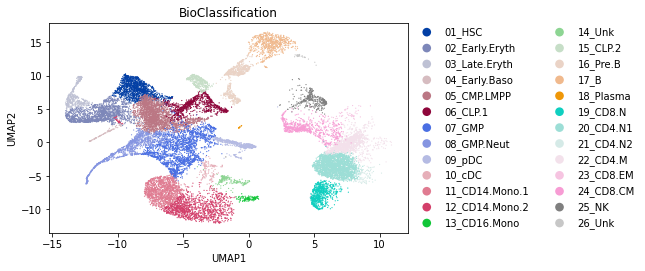

In [3]:
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='BioClassification')

To confirm the cell type labels that come with this dataset, I compiled the following table that shows which of the proteins included in this study should be expressed by which cell types. Not all of the cell types they've included can be identified using only these 21 proteins and they probably also used gene expression to identify cell types but a lot of the main categories can be picked out fairly easily.

All leukocytes are positive for CD45. 

CD45RA and RO are splice variants of CD45.

| Cell type | Markers |
|----------|----------|
|HSC | CD34+, CD38-, CD90+ |
|Myeloid Progenitors | CD34+, CD38+, CD33+ |
|Lymphoid Progenitors | CD34+, CD38+, CD10+ |
|Erythroid Progenitors | CD34+, CD38+, CD45RA+ |
|GMP | CD34+, CD38+, CD33+, CD15+ |
|Neutrophils | CD34+, CD38+, CD33+ | 
|Eosinophils | CD34+, CD38+, CD33+, CD123+ |
|Basophils | CD34+, CD38+, CD33+, CD123+ |
|CD14 Monocytes | CD34-, CD14+, CD33+, CD15+, CD45RA+ |
|CD16 Monocytes | CD34-, CD16+, CD33+, CD15+, CD45RA+ |
|Conventional Dendritic Cells | CD45RA+, CD4+ |
|Plasmacytoid Dendritic Cells | CD45RA+, CD4+, CD123+ |
|B Cells | CD45RA+, CD19+ |
|All T Cells | CD3+ |
|CD4 Naive T Cells | CD45RA+, CD4+, CD127+, CD45RO-, CD25- |
|CD4 Central Memory T Cells | CD4+, CD25+, CD45RA-, CD45RO+, CD127+ |
|CD4 Effector Memory T Cells | CD4+, CD25-, CD45RA-, CD45RO+, CD127+ |
|CD8 Naive T Cells | CD8A+, CD45RA+, CD45RO- |
|CD8 Central Memory T Cells | CD8A+, CD45RA-, CD45RO+, TIGIT+ |
|CD8 Effector Memory T Cells | CD8A+, CD45RA-, CD45RO+ |
|NK Cells | CD56+, CD3-, TIGIT+ |

In [4]:
# create df for visualisatin
df = pd.concat([adata.obs['BioClassification'], adt], axis = 1)

/home/sarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




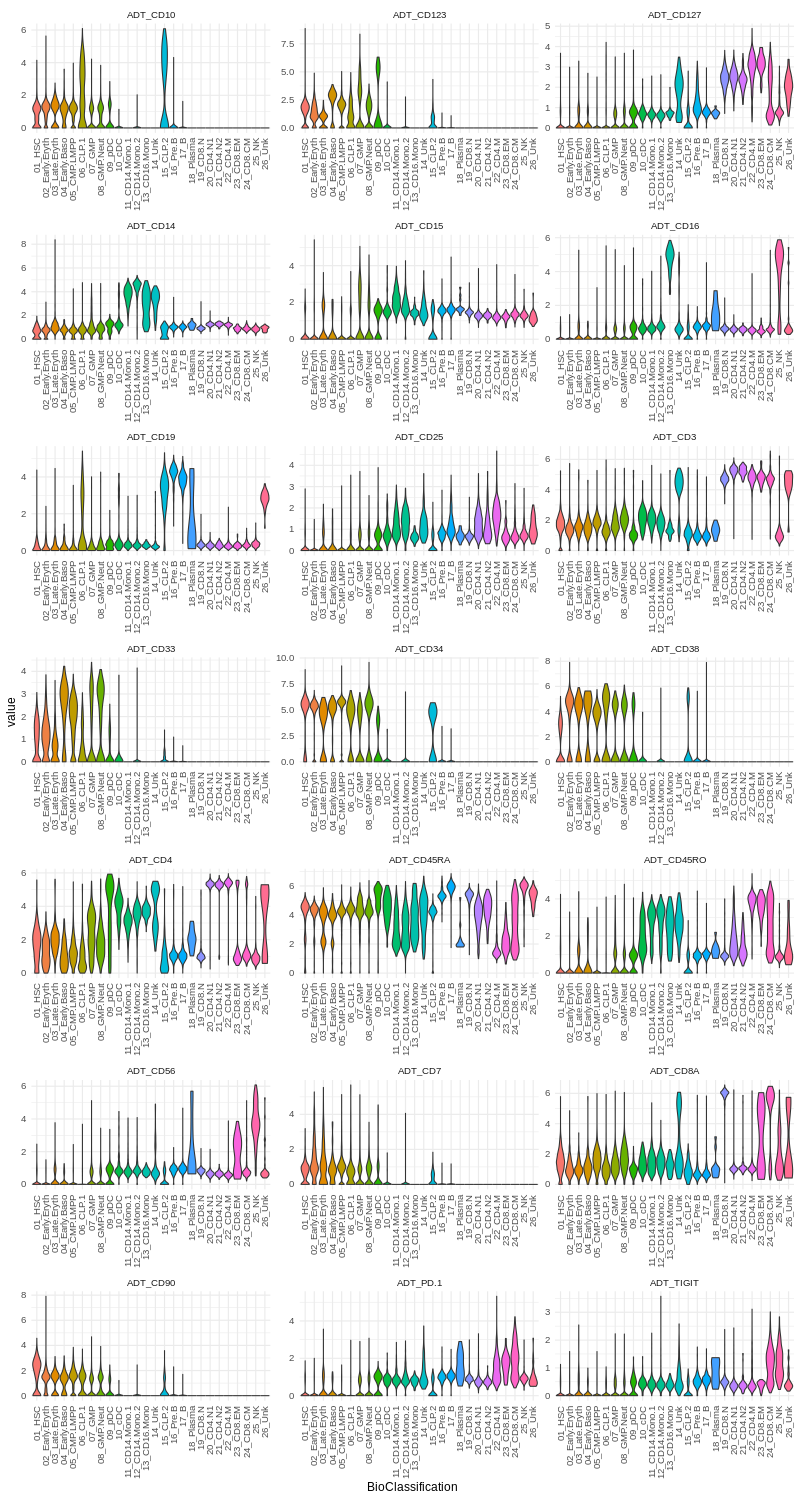

In [5]:
%%R -i df -h 1500 -w 800
library(ggplot2)
library(dplyr)
library(tidyr)

# check which cell types the different proteins are being expressed in
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = BioClassification, y = value, fill = BioClassification)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~Protein, scales = 'free', nrow = 7) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

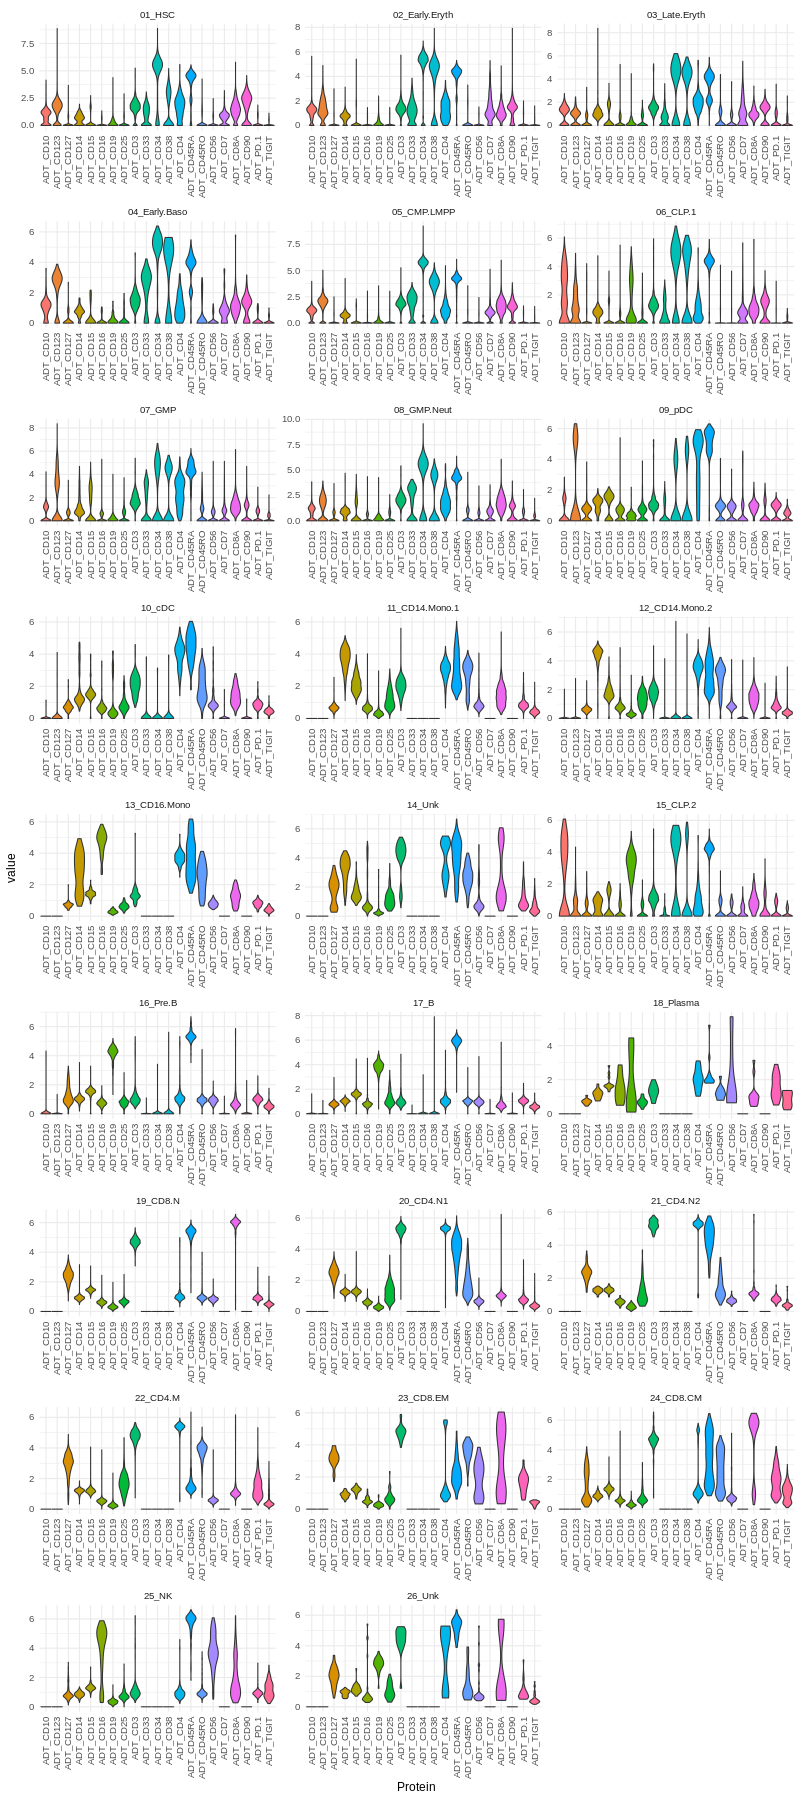

In [6]:
%%R -i df -h 1800 -w 800

# check which proteins are being expressed in each cell type
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = Protein, y = value, fill = Protein)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~BioClassification, scales = 'free', nrow = 9) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

All cell type labels look really good so far. Seeing as I'm going to be using this dataset as my 'Gold Standard' for predicting cell type labels in other datasets, I want to see if I can identify the two categories they have listed as '14_Unk' and '26_Unk'. I also want to see if it's possible to identify more T cell categories such as Tregs.

In [ ]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

/home/sarah/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sarah/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/utils.py", 

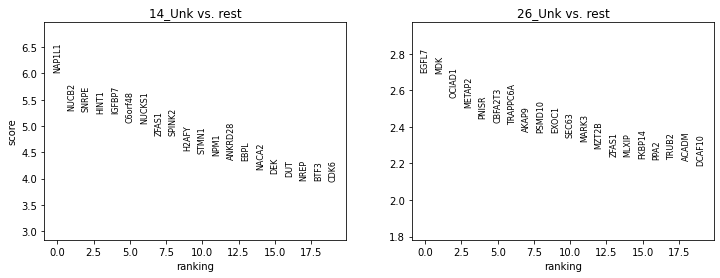

In [98]:
# First need to normalise the data
adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata.raw = adata

# Identify which genes are differentially expressed by the 2 unknown categories to try figure out what they are
sc.tl.rank_genes_groups(adata, groupby='BioClassification', groups=['14_Unk', '26_Unk'], key_added = 'rank_genes_unk')
sc.pl.rank_genes_groups(adata, key='rank_genes_unk', sharey=False)

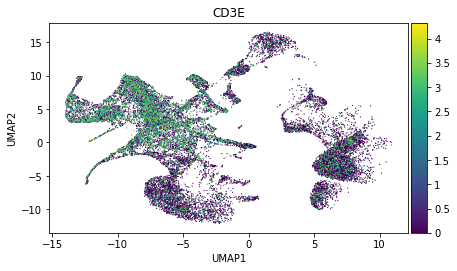

/home/sarah/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/sarah/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


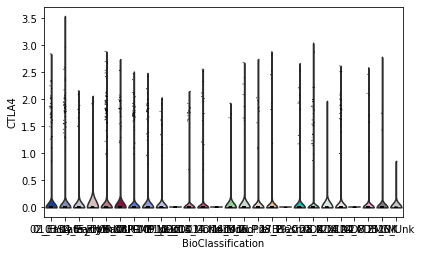

In [113]:
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='CD3E')
sc.pl.violin(adata, 'CTLA4', groupby='BioClassification')